## <center> Decision Tree Regression (Capped dataset)
#### <center> By: $\color{red}{\text{Amirehsan Ghasemi}}$

### Importing Modules

In [1]:
#....> Importing the base libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time


#....> AI/ML modules
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

#....> Preventing warnings
import warnings      #....> Prevent from printing the warning of plotting
warnings.simplefilter(action="ignore", category=FutureWarning)

#....................................................................................................
#....................................................................................................
print('Modules are imported')  #....> If prints, this means that the modules are imported correctly

Modules are imported


### Read in all our data

In [2]:
df = pd.read_csv('housing.csv')  #....> Importing dataframe
rows,columns = df.shape
print("Dataframe number of rows: ", rows)
print("Dataframe number of columns: ", columns)

Dataframe number of rows:  20640
Dataframe number of columns:  10


### Checking the data structure

In [3]:
df.head(n=5)     # Show the first 5 rows (each row: one district)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


#### Notice: All features are numerical, except the $\color{red}{\text{ocean_proximity}}$. Its type is object and its text feature (Categorical feature)

#### It might be interesting to add the possibly helpful attributes combinations and study their effect on modeling. So:

In [4]:
df["rooms_per_household"]      = df["total_rooms"]/df["households"]
df["bedrooms_per_room"]        = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"] = df["population"]/df["households"]

df.head(n=5)    #....> Show the first 5 rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,6.281853,0.172096,2.181467


### Handling categorical feature (ocean_proximity)

#### First, we have to explore this categorical feature

In [5]:
df["ocean_proximity"].value_counts()    #....> Return a Series containing counts of unique values

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

#### Asssigning numerical values to ocean proximity in the gradient order: the lower the number the further away is the house from the ocean. This gradient is chosen for the better and easier interpretation of models results (feature importances)

In [6]:
df.loc[df['ocean_proximity'] == 'NEAR OCEAN', 'ocean_proximity'] = 4
df.loc[df['ocean_proximity'] == 'NEAR BAY', 'ocean_proximity']   = 3
df.loc[df['ocean_proximity'] == '<1H OCEAN', 'ocean_proximity']  = 2
df.loc[df['ocean_proximity'] == 'INLAND', 'ocean_proximity']     = 1
df.loc[df['ocean_proximity'] == 'ISLAND', 'ocean_proximity']     = 0

df     #....> Show the dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,3,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,3,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,3,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,3,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3,6.281853,0.172096,2.181467
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,1,5.045455,0.224625,2.560606
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,1,6.114035,0.215208,3.122807
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,1,5.205543,0.215173,2.325635
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,1,5.329513,0.219892,2.123209


### Splitting the dataset

#### Now the data will be splitted in train and test set to avoid the data leakage and bias during the further preprocessing steps, which include cleaning the missing values and feature scaling.

In [7]:
train_set1, test_set1 = train_test_split(df, test_size=0.2, random_state=1)
print("Training Data:", len(train_set1))
print("Testing Data:", len(test_set1))

Training Data: 16512
Testing Data: 4128


### Data cleaning (Training set and Testing set)

#### Check if there are any missing values (NaN or None)

In [8]:
#....> For Training set
missing_values_count = train_set1.isnull().sum()
missing_values_count[:]

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms              163
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity               0
rooms_per_household           0
bedrooms_per_room           163
population_per_household      0
dtype: int64

In [9]:
#....> For Testing set
missing_values_count = test_set1.isnull().sum()
missing_values_count[:]

longitude                    0
latitude                     0
housing_median_age           0
total_rooms                  0
total_bedrooms              44
population                   0
households                   0
median_income                0
median_house_value           0
ocean_proximity              0
rooms_per_household          0
bedrooms_per_room           44
population_per_household     0
dtype: int64

### It's helpful to see what percentage of the values in our dataset were missing. It gives us a better sense of the scale of this problem

In [10]:
#....> Defining a function to find the percentage of the values in our dataset were missing
def finding_percentage(df):
    total_cells     = np.product(df.shape)
    total_missing   = missing_values_count.sum()
    percent_missing = (total_missing/total_cells)*100
    return percent_missing

In [11]:
#....> Calling the finding_percange functtion
print('Percent of data that is missing in Training set:', finding_percentage(train_set1))
print('Percent of data that is missing in Testing set:', finding_percentage(test_set1))

Percent of data that is missing in Training set: 0.04099582587954681
Percent of data that is missing in Testing set: 0.16398330351818724


### Replacing NAN with Imputer (median) using Scikit-learn

In [12]:
#....> Training Set
imputer = SimpleImputer(strategy = "median") #....> Using medain
housing_numerical_attributes = train_set1.drop("ocean_proximity", axis = 1)
imputer.fit(housing_numerical_attributes)  
X1 = imputer.transform(housing_numerical_attributes)

In [13]:
#....> Testing Set
imputer = SimpleImputer(strategy = "median")  #....> Using medain
housing_numerical_attributes1 = test_set1.drop("ocean_proximity", axis = 1)
imputer.fit(housing_numerical_attributes)  
X2 = imputer.transform(housing_numerical_attributes1)

#### For Both Training and Testing sets the NAN values are replaced with medain
#### Put back the ocean proximity in train and test sets:

In [14]:
#....> Training Set
train_set = pd.DataFrame(X1, columns = housing_numerical_attributes.columns, index = housing_numerical_attributes.index)
train_set.insert(9,"ocean_proximity",df["ocean_proximity"],True)
train_set    #....> Show the Training set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
15961,-122.43,37.71,52.0,1410.0,286.0,879.0,282.0,3.1908,255600.0,3,5.000000,0.202837,3.117021
1771,-122.35,37.95,42.0,1485.0,290.0,971.0,303.0,3.6094,114600.0,3,4.900990,0.195286,3.204620
16414,-121.24,37.90,16.0,50.0,10.0,20.0,6.0,2.6250,137500.0,1,8.333333,0.200000,3.333333
5056,-118.35,34.02,34.0,5218.0,1576.0,3538.0,1371.0,1.5143,118800.0,2,3.805981,0.302031,2.580598
8589,-118.39,33.89,38.0,1851.0,332.0,750.0,314.0,7.3356,422700.0,2,5.894904,0.179363,2.388535
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,-117.88,33.76,17.0,1768.0,474.0,1079.0,436.0,1.7823,205300.0,2,4.055046,0.268100,2.474771
17289,-119.63,34.42,42.0,1765.0,263.0,753.0,260.0,8.5608,500001.0,2,6.788462,0.149008,2.896154
5192,-118.26,33.93,42.0,1433.0,295.0,775.0,293.0,1.1326,104800.0,2,4.890785,0.205862,2.645051
12172,-117.16,33.73,10.0,2381.0,454.0,1323.0,477.0,2.6322,140700.0,1,4.991614,0.190676,2.773585


In [15]:
#....> Testing Set
test_set = pd.DataFrame(X2, columns = housing_numerical_attributes1.columns, index = housing_numerical_attributes1.index)

test_set.insert(9,"ocean_proximity",df["ocean_proximity"],True)
test_set  #....> Show the Testing set

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
4712,-118.36,34.06,39.0,2810.0,670.0,1109.0,624.0,3.2500,355000.0,2,4.503205,0.238434,1.777244
2151,-119.78,36.78,37.0,2185.0,455.0,1143.0,438.0,1.9784,70700.0,1,4.988584,0.208238,2.609589
15927,-122.42,37.73,46.0,1819.0,411.0,1534.0,406.0,4.0132,229400.0,3,4.480296,0.225948,3.778325
82,-122.28,37.81,52.0,340.0,97.0,200.0,87.0,1.5208,112500.0,3,3.908046,0.285294,2.298851
8161,-118.13,33.82,37.0,1530.0,290.0,711.0,283.0,5.1795,225400.0,2,5.406360,0.189542,2.512367
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,-119.70,36.82,25.0,2379.0,540.0,1482.0,484.0,2.3173,68200.0,1,4.915289,0.226986,3.061983
5341,-118.44,34.04,49.0,32.0,7.0,14.0,7.0,2.1875,225000.0,2,4.571429,0.218750,2.000000
16888,-122.37,37.60,26.0,15.0,3.0,11.0,3.0,5.0480,350000.0,4,5.000000,0.200000,3.666667
6823,-118.10,34.09,42.0,1460.0,289.0,829.0,273.0,4.8750,227300.0,2,5.347985,0.197945,3.036630


### Feature Scaling (Standardization)

In [16]:
train_set_without_target = train_set.drop("median_house_value", axis=1) #....> drop labels for training set 
train_set_without_target    

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
15961,-122.43,37.71,52.0,1410.0,286.0,879.0,282.0,3.1908,3,5.000000,0.202837,3.117021
1771,-122.35,37.95,42.0,1485.0,290.0,971.0,303.0,3.6094,3,4.900990,0.195286,3.204620
16414,-121.24,37.90,16.0,50.0,10.0,20.0,6.0,2.6250,1,8.333333,0.200000,3.333333
5056,-118.35,34.02,34.0,5218.0,1576.0,3538.0,1371.0,1.5143,2,3.805981,0.302031,2.580598
8589,-118.39,33.89,38.0,1851.0,332.0,750.0,314.0,7.3356,2,5.894904,0.179363,2.388535
...,...,...,...,...,...,...,...,...,...,...,...,...
10955,-117.88,33.76,17.0,1768.0,474.0,1079.0,436.0,1.7823,2,4.055046,0.268100,2.474771
17289,-119.63,34.42,42.0,1765.0,263.0,753.0,260.0,8.5608,2,6.788462,0.149008,2.896154
5192,-118.26,33.93,42.0,1433.0,295.0,775.0,293.0,1.1326,2,4.890785,0.205862,2.645051
12172,-117.16,33.73,10.0,2381.0,454.0,1323.0,477.0,2.6322,1,4.991614,0.190676,2.773585


In [17]:
test_set_without_target = test_set.drop("median_house_value", axis=1) #....> drop labels for testing set
test_set_without_target

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
4712,-118.36,34.06,39.0,2810.0,670.0,1109.0,624.0,3.2500,2,4.503205,0.238434,1.777244
2151,-119.78,36.78,37.0,2185.0,455.0,1143.0,438.0,1.9784,1,4.988584,0.208238,2.609589
15927,-122.42,37.73,46.0,1819.0,411.0,1534.0,406.0,4.0132,3,4.480296,0.225948,3.778325
82,-122.28,37.81,52.0,340.0,97.0,200.0,87.0,1.5208,3,3.908046,0.285294,2.298851
8161,-118.13,33.82,37.0,1530.0,290.0,711.0,283.0,5.1795,2,5.406360,0.189542,2.512367
...,...,...,...,...,...,...,...,...,...,...,...,...
2319,-119.70,36.82,25.0,2379.0,540.0,1482.0,484.0,2.3173,1,4.915289,0.226986,3.061983
5341,-118.44,34.04,49.0,32.0,7.0,14.0,7.0,2.1875,2,4.571429,0.218750,2.000000
16888,-122.37,37.60,26.0,15.0,3.0,11.0,3.0,5.0480,4,5.000000,0.200000,3.666667
6823,-118.10,34.09,42.0,1460.0,289.0,829.0,273.0,4.8750,2,5.347985,0.197945,3.036630


In [18]:
# Creating pandas series full of zeros to store the standard deviation and the mean from the training set.
std_dev_tr= pd.Series({col:0 for col in train_set_without_target.columns}, dtype="float32")
mean_tr= pd.Series({col:0 for col in train_set_without_target.columns}, dtype="float32")

# Getting the values for the mean and standard deviation from the training dataset.
for col in train_set_without_target.columns:
    std_dev_tr[col]= train_set_without_target[col].std()
    mean_tr[col]= train_set_without_target[col].mean()
    # Changing the training data so it is normalized with the mean and standard deviation from the training set.
    train_set_without_target[col]=(train_set_without_target[col]-mean_tr[col])/std_dev_tr[col]

for col in test_set_without_target.columns:
    # Changing the testing data so it is normalized with the mean and standard deviation from the training set.
    test_set_without_target[col]=(test_set_without_target[col]-mean_tr[col])/std_dev_tr[col]

In [19]:
train_set_without_target

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
15961,-1.422467,0.972261,1.858847,-0.564960,-0.601575,-0.486099,-0.571577,-0.362315,0.974077,-0.168768,-0.176681,0.001901
1771,-1.382618,1.084563,1.064316,-0.530499,-0.592027,-0.404231,-0.516666,-0.141019,0.974077,-0.206649,-0.306201,0.009455
16414,-0.829713,1.061167,-1.001464,-1.189839,-1.260385,-1.250499,-1.293259,-0.661429,-1.087176,1.106550,-0.225343,0.020553
5056,0.609833,-0.754389,0.428691,1.184701,2.477644,1.880071,2.275932,-1.248609,-0.05655,-0.625594,1.524846,-0.044352
8589,0.589909,-0.815219,0.746504,-0.362334,-0.491774,-0.600893,-0.487903,1.828865,-0.05655,0.173618,-0.579347,-0.060913
...,...,...,...,...,...,...,...,...,...,...,...,...
10955,0.843946,-0.876050,-0.922011,-0.400469,-0.152821,-0.308125,-0.168899,-1.106929,-0.05655,-0.530303,0.942798,-0.053477
17289,-0.027751,-0.567218,1.064316,-0.401848,-0.656476,-0.598223,-0.629102,2.476576,-0.05655,0.515489,-1.100022,-0.017143
5192,0.654663,-0.796502,1.064316,-0.554392,-0.580093,-0.578646,-0.542814,-1.450398,-0.05655,-0.210553,-0.124792,-0.038795
12172,1.202587,-0.890087,-1.478182,-0.118815,-0.200561,-0.090996,-0.061692,-0.657623,-1.087176,-0.171977,-0.385278,-0.027712


In [20]:
train_set_without_target.insert(12,"median_house_value",train_set["median_house_value"]) #Put back the target values for train set
train_set_without_target

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,median_house_value
15961,-1.422467,0.972261,1.858847,-0.564960,-0.601575,-0.486099,-0.571577,-0.362315,0.974077,-0.168768,-0.176681,0.001901,255600.0
1771,-1.382618,1.084563,1.064316,-0.530499,-0.592027,-0.404231,-0.516666,-0.141019,0.974077,-0.206649,-0.306201,0.009455,114600.0
16414,-0.829713,1.061167,-1.001464,-1.189839,-1.260385,-1.250499,-1.293259,-0.661429,-1.087176,1.106550,-0.225343,0.020553,137500.0
5056,0.609833,-0.754389,0.428691,1.184701,2.477644,1.880071,2.275932,-1.248609,-0.05655,-0.625594,1.524846,-0.044352,118800.0
8589,0.589909,-0.815219,0.746504,-0.362334,-0.491774,-0.600893,-0.487903,1.828865,-0.05655,0.173618,-0.579347,-0.060913,422700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,0.843946,-0.876050,-0.922011,-0.400469,-0.152821,-0.308125,-0.168899,-1.106929,-0.05655,-0.530303,0.942798,-0.053477,205300.0
17289,-0.027751,-0.567218,1.064316,-0.401848,-0.656476,-0.598223,-0.629102,2.476576,-0.05655,0.515489,-1.100022,-0.017143,500001.0
5192,0.654663,-0.796502,1.064316,-0.554392,-0.580093,-0.578646,-0.542814,-1.450398,-0.05655,-0.210553,-0.124792,-0.038795,104800.0
12172,1.202587,-0.890087,-1.478182,-0.118815,-0.200561,-0.090996,-0.061692,-0.657623,-1.087176,-0.171977,-0.385278,-0.027712,140700.0


In [21]:
train=train_set_without_target
train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,median_house_value
15961,-1.422467,0.972261,1.858847,-0.564960,-0.601575,-0.486099,-0.571577,-0.362315,0.974077,-0.168768,-0.176681,0.001901,255600.0
1771,-1.382618,1.084563,1.064316,-0.530499,-0.592027,-0.404231,-0.516666,-0.141019,0.974077,-0.206649,-0.306201,0.009455,114600.0
16414,-0.829713,1.061167,-1.001464,-1.189839,-1.260385,-1.250499,-1.293259,-0.661429,-1.087176,1.106550,-0.225343,0.020553,137500.0
5056,0.609833,-0.754389,0.428691,1.184701,2.477644,1.880071,2.275932,-1.248609,-0.05655,-0.625594,1.524846,-0.044352,118800.0
8589,0.589909,-0.815219,0.746504,-0.362334,-0.491774,-0.600893,-0.487903,1.828865,-0.05655,0.173618,-0.579347,-0.060913,422700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,0.843946,-0.876050,-0.922011,-0.400469,-0.152821,-0.308125,-0.168899,-1.106929,-0.05655,-0.530303,0.942798,-0.053477,205300.0
17289,-0.027751,-0.567218,1.064316,-0.401848,-0.656476,-0.598223,-0.629102,2.476576,-0.05655,0.515489,-1.100022,-0.017143,500001.0
5192,0.654663,-0.796502,1.064316,-0.554392,-0.580093,-0.578646,-0.542814,-1.450398,-0.05655,-0.210553,-0.124792,-0.038795,104800.0
12172,1.202587,-0.890087,-1.478182,-0.118815,-0.200561,-0.090996,-0.061692,-0.657623,-1.087176,-0.171977,-0.385278,-0.027712,140700.0


In [22]:
test_set_without_target.insert(12,"median_house_value",test_set["median_house_value"]) #Put back the target values for test set
test_set_without_target

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,median_house_value
4712,0.604852,-0.735672,0.825957,0.078298,0.315029,-0.281429,0.322682,-0.331018,-0.05655,-0.358840,0.433935,-0.113623,355000.0
2151,-0.102468,0.537089,0.667051,-0.208871,-0.198174,-0.251173,-0.163669,-1.003259,-1.087176,-0.173136,-0.084033,-0.041853,70700.0
15927,-1.417486,0.981619,1.382128,-0.377037,-0.303201,0.096767,-0.247342,0.072453,0.974077,-0.367605,0.219760,0.058923,229400.0
82,-1.347750,1.019053,1.858847,-1.056592,-1.052717,-1.090322,-1.081461,-1.245173,0.974077,-0.586545,1.237744,-0.068646,112500.0
8161,0.719418,-0.847974,0.667051,-0.509823,-0.592027,-0.635598,-0.568962,0.689026,-0.05655,-0.013297,-0.404725,-0.050236,225400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,-0.062619,0.555806,-0.286386,-0.119733,0.004721,0.050494,-0.043389,-0.824097,-1.087176,-0.201178,0.237562,-0.002844,68200.0
5341,0.565003,-0.745030,1.620488,-1.198109,-1.267546,-1.255839,-1.290644,-0.892717,-0.05655,-0.332738,0.096284,-0.094415,225000.0
16888,-1.392580,0.920789,-0.206933,-1.205920,-1.277094,-1.258508,-1.301103,0.619508,2.004703,-0.168768,-0.225343,0.049295,350000.0
6823,0.734361,-0.721634,1.064316,-0.541986,-0.594414,-0.530593,-0.595110,0.528050,-0.05655,-0.035631,-0.260590,-0.005030,227300.0


In [23]:
test=test_set_without_target
test

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household,median_house_value
4712,0.604852,-0.735672,0.825957,0.078298,0.315029,-0.281429,0.322682,-0.331018,-0.05655,-0.358840,0.433935,-0.113623,355000.0
2151,-0.102468,0.537089,0.667051,-0.208871,-0.198174,-0.251173,-0.163669,-1.003259,-1.087176,-0.173136,-0.084033,-0.041853,70700.0
15927,-1.417486,0.981619,1.382128,-0.377037,-0.303201,0.096767,-0.247342,0.072453,0.974077,-0.367605,0.219760,0.058923,229400.0
82,-1.347750,1.019053,1.858847,-1.056592,-1.052717,-1.090322,-1.081461,-1.245173,0.974077,-0.586545,1.237744,-0.068646,112500.0
8161,0.719418,-0.847974,0.667051,-0.509823,-0.592027,-0.635598,-0.568962,0.689026,-0.05655,-0.013297,-0.404725,-0.050236,225400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2319,-0.062619,0.555806,-0.286386,-0.119733,0.004721,0.050494,-0.043389,-0.824097,-1.087176,-0.201178,0.237562,-0.002844,68200.0
5341,0.565003,-0.745030,1.620488,-1.198109,-1.267546,-1.255839,-1.290644,-0.892717,-0.05655,-0.332738,0.096284,-0.094415,225000.0
16888,-1.392580,0.920789,-0.206933,-1.205920,-1.277094,-1.258508,-1.301103,0.619508,2.004703,-0.168768,-0.225343,0.049295,350000.0
6823,0.734361,-0.721634,1.064316,-0.541986,-0.594414,-0.530593,-0.595110,0.528050,-0.05655,-0.035631,-0.260590,-0.005030,227300.0


## Modeling

#### First, we will split between features and target value (labels) for train set:

In [24]:
housing = train.drop("median_house_value", axis=1)   #....> drop labels for training set
housing_labels = train["median_house_value"].copy()

housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
15961,-1.422467,0.972261,1.858847,-0.564960,-0.601575,-0.486099,-0.571577,-0.362315,0.974077,-0.168768,-0.176681,0.001901
1771,-1.382618,1.084563,1.064316,-0.530499,-0.592027,-0.404231,-0.516666,-0.141019,0.974077,-0.206649,-0.306201,0.009455
16414,-0.829713,1.061167,-1.001464,-1.189839,-1.260385,-1.250499,-1.293259,-0.661429,-1.087176,1.106550,-0.225343,0.020553
5056,0.609833,-0.754389,0.428691,1.184701,2.477644,1.880071,2.275932,-1.248609,-0.05655,-0.625594,1.524846,-0.044352
8589,0.589909,-0.815219,0.746504,-0.362334,-0.491774,-0.600893,-0.487903,1.828865,-0.05655,0.173618,-0.579347,-0.060913
...,...,...,...,...,...,...,...,...,...,...,...,...
10955,0.843946,-0.876050,-0.922011,-0.400469,-0.152821,-0.308125,-0.168899,-1.106929,-0.05655,-0.530303,0.942798,-0.053477
17289,-0.027751,-0.567218,1.064316,-0.401848,-0.656476,-0.598223,-0.629102,2.476576,-0.05655,0.515489,-1.100022,-0.017143
5192,0.654663,-0.796502,1.064316,-0.554392,-0.580093,-0.578646,-0.542814,-1.450398,-0.05655,-0.210553,-0.124792,-0.038795
12172,1.202587,-0.890087,-1.478182,-0.118815,-0.200561,-0.090996,-0.061692,-0.657623,-1.087176,-0.171977,-0.385278,-0.027712


In [25]:
housing_labels

15961    255600.0
1771     114600.0
16414    137500.0
5056     118800.0
8589     422700.0
           ...   
10955    205300.0
17289    500001.0
5192     104800.0
12172    140700.0
235      126000.0
Name: median_house_value, Length: 16512, dtype: float64

#### Second, we will split between features and target value (labels) for test set

In [26]:
housing_t = test.drop("median_house_value", axis=1)   #....> drop labels for test set
housing_labels_t = test["median_house_value"].copy()

housing_t

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_room,population_per_household
4712,0.604852,-0.735672,0.825957,0.078298,0.315029,-0.281429,0.322682,-0.331018,-0.05655,-0.358840,0.433935,-0.113623
2151,-0.102468,0.537089,0.667051,-0.208871,-0.198174,-0.251173,-0.163669,-1.003259,-1.087176,-0.173136,-0.084033,-0.041853
15927,-1.417486,0.981619,1.382128,-0.377037,-0.303201,0.096767,-0.247342,0.072453,0.974077,-0.367605,0.219760,0.058923
82,-1.347750,1.019053,1.858847,-1.056592,-1.052717,-1.090322,-1.081461,-1.245173,0.974077,-0.586545,1.237744,-0.068646
8161,0.719418,-0.847974,0.667051,-0.509823,-0.592027,-0.635598,-0.568962,0.689026,-0.05655,-0.013297,-0.404725,-0.050236
...,...,...,...,...,...,...,...,...,...,...,...,...
2319,-0.062619,0.555806,-0.286386,-0.119733,0.004721,0.050494,-0.043389,-0.824097,-1.087176,-0.201178,0.237562,-0.002844
5341,0.565003,-0.745030,1.620488,-1.198109,-1.267546,-1.255839,-1.290644,-0.892717,-0.05655,-0.332738,0.096284,-0.094415
16888,-1.392580,0.920789,-0.206933,-1.205920,-1.277094,-1.258508,-1.301103,0.619508,2.004703,-0.168768,-0.225343,0.049295
6823,0.734361,-0.721634,1.064316,-0.541986,-0.594414,-0.530593,-0.595110,0.528050,-0.05655,-0.035631,-0.260590,-0.005030


In [27]:
housing_labels_t

4712     355000.0
2151      70700.0
15927    229400.0
82       112500.0
8161     225400.0
           ...   
2319      68200.0
5341     225000.0
16888    350000.0
6823     227300.0
11878    141700.0
Name: median_house_value, Length: 4128, dtype: float64

In [28]:
housing_t.isnull().sum()

longitude                   0
latitude                    0
housing_median_age          0
total_rooms                 0
total_bedrooms              0
population                  0
households                  0
median_income               0
ocean_proximity             0
rooms_per_household         0
bedrooms_per_room           0
population_per_household    0
dtype: int64

## Creating a Decision tree regression model:

In [29]:
dtr = DecisionTreeRegressor()      # Create the model: Decision tree regression 

In [30]:
%%time
dtr.fit(housing, housing_labels)   # Fit to the Training set

CPU times: user 192 ms, sys: 0 ns, total: 192 ms
Wall time: 191 ms


DecisionTreeRegressor()

In [31]:
print("DTR model score Training Set:", dtr.score(housing, housing_labels))
print("DTR model score Testing Set:", dtr.score(housing_t, housing_labels_t))

DTR model score Training Set: 1.0
DTR model score Testing Set: 0.6301184837293871


In [32]:
prediction = dtr.predict(housing_t)  #....> Decision Tree Regression Model Evaluation (on Testing set)

In [33]:
print("RMSE for Testing set: ", np.sqrt(mean_squared_error(housing_labels_t,prediction)))
print('MAE for Testing set::', metrics.mean_absolute_error(housing_labels_t,prediction))
print("R^2 score for Testing set: ", r2_score(housing_labels_t,prediction))

RMSE for Testing set:  69654.1598251614
MAE for Testing set:: 44181.43362403101
R^2 score for Testing set:  0.6301184837293871


#### We got 100% score on Training set. On testing set we got almost 63% score because we didn't do any hyperparameters tuning. Due to which depth of tree increased and our model did the overfitting. To solve this problem  hyperparameter tuning will be utilized.

#### We can use GridSearch or RandomizedSearch for hyper parameters tuning.


<AxesSubplot:xlabel='median_house_value', ylabel='Density'>

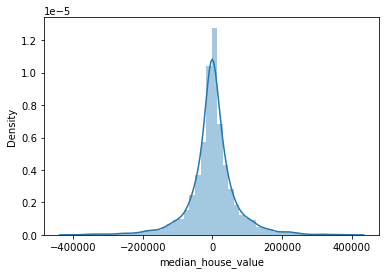

In [34]:
## Distribution plot between our label  and predicted values:
# checking difference between label and predicted label
sns.distplot(housing_labels_t-prediction)

#### We can't get any conclusion about our model accrording the bell shape. Bell curve only tell us the range of predicted values are with in the same range as our original data range values are.

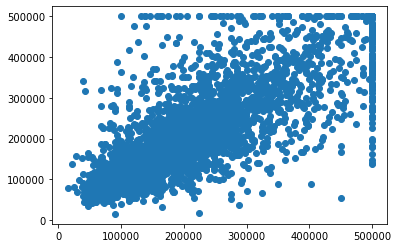

In [35]:
#...> checking predicted lables and our labeles using a scatter plot
plt.scatter(housing_labels_t, prediction)

## <center> Hyper Parameter tuning

In [36]:
#....> Hyper parameters range intialization for tuning 
#....> Gridsearch to find the best parameters for our decision tree model.
    
params = {"criterion": ["squared_error", "absolute_error"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }    
    
#....> calculating different regression metrics
tuning_dtr = GridSearchCV(dtr, param_grid=params, scoring='neg_mean_squared_error', cv=3, verbose=3, n_jobs=-1)

In [37]:
%%time   
tuning_dtr.fit(housing, housing_labels)  #....> Fiting the tuned model on the traning set 


Fitting 3 folds for each of 162 candidates, totalling 486 fits
CPU times: user 1.29 s, sys: 184 ms, total: 1.47 s
Wall time: 3min 3s


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [2, 6, 8], 'max_leaf_nodes': [5, 20, 100],
                         'min_samples_leaf': [20, 40, 100],
                         'min_samples_split': [10, 20, 40]},
             scoring='neg_mean_squared_error', verbose=3)

In [38]:
tuning_dtr.best_params_

{'criterion': 'squared_error',
 'max_depth': 8,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 20,
 'min_samples_split': 10}

In [39]:
tuning_dtr.best_score_

-3781195877.168773

In [40]:
tuning_dtr.best_estimator_


DecisionTreeRegressor(max_depth=8, max_leaf_nodes=100, min_samples_leaf=20,
                      min_samples_split=10)

In [41]:
%%time
tuned_pred = tuning_dtr.best_estimator_.predict(housing_t) #....> Applying it on the testing set (tuned version)

CPU times: user 3.99 ms, sys: 92 µs, total: 4.08 ms
Wall time: 3.53 ms


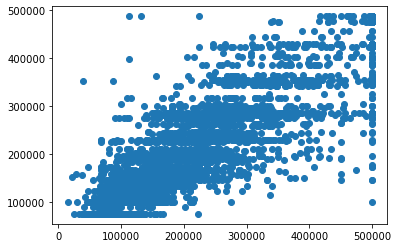

In [42]:
#....> checking predicted lables (tuned version) and our labeles using a scatter plot
plt.scatter(housing_labels_t,tuned_pred)

In [43]:
print('MAE:', metrics.mean_absolute_error(housing_labels_t,tuned_pred))
print('MSE:', metrics.mean_squared_error(housing_labels_t, tuned_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(housing_labels_t, tuned_pred)))
print("R^2 score for Testing set: ", r2_score(housing_labels_t,tuned_pred))

MAE: 42239.83026269269
MSE: 3726011280.223576
RMSE: 61041.06224684803
R^2 score for Testing set:  0.7159383021912461


In [44]:
#....> Finiding feature importances
features=housing_t.columns
importances=tuning_dtr.best_estimator_.feature_importances_
combined=pd.Series(importances, features)
combined

longitude                   0.036127
latitude                    0.022518
housing_median_age          0.028593
total_rooms                 0.000350
total_bedrooms              0.000707
population                  0.000000
households                  0.000000
median_income               0.590051
ocean_proximity             0.191687
rooms_per_household         0.003988
bedrooms_per_room           0.004577
population_per_household    0.121401
dtype: float64

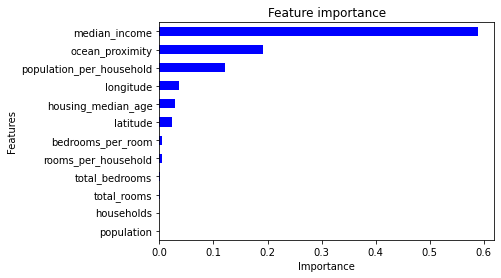

In [45]:
#....> Ploting feature importances
from matplotlib.pyplot import figure
figure()
combined.sort_values().plot.barh(color="b")
plt.title("Feature importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()



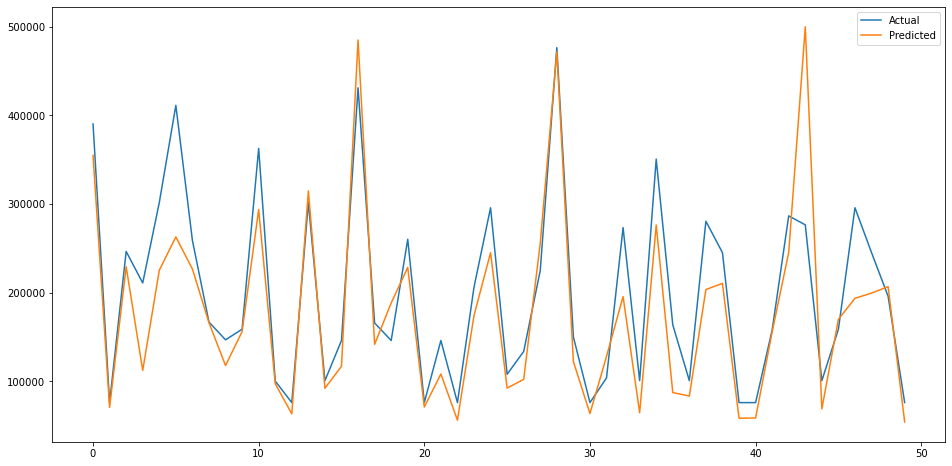

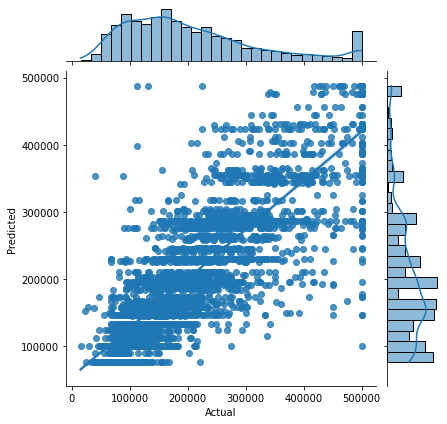

In [46]:
#....> Ploting the results
test = pd.DataFrame({'Predicted':tuned_pred,'Actual':housing_labels_t})
fig = plt.figure(figsize=(16,8))
test = test.reset_index()
test = test.drop(['index'],axis=1)
plt.plot(test[:50])
plt.legend(['Actual','Predicted'])
sns.jointplot(x='Actual',y='Predicted',data=test,kind="reg")
